# YTSG Random Forest

This script trains a random forest algorithm against the classified page data

In [1]:
# Import required libraries and set up project

import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split, GridSearchCV
from sklearn.preprocessing import MinMaxScaler
import sqlite3
import matplotlib.pyplot as plt
import itertools
import pickle

In [2]:
# Get training data and define feature columns
conn = sqlite3.connect('ytsg-dataset.db')
query = """SELECT 
    * ,
    (LENGTH(categories) - LENGTH(REPLACE(categories, "||", "|")) +1) AS category_count 
FROM manual_page_classifications LIMIT 5000"""
df = pd.read_sql_query(query, conn)

feature_columns = [
    'total_length',
    'file_page',
    'target_words_in_section_titles',
    'category_count',
    #'section_count',
    'image_count',
    #'audio_count'
]

## Try all combinations of feature columns
This is a time-consuming process that outputs the top 5 most accurate combinations of feature columns.
The function is wrapped in a False if to avoid the long run time after features have been identified.

In [3]:
if False:
    # Split up training and test sets
    x_train, x_test, y_train, y_test = train_test_split(df, df['rating_class'], test_size=0.30, random_state=11)

    # Generate all possible combinations of feature columns
    all_combinations = []
    for r in range(1, len(feature_columns) + 1):
        combinations_object = itertools.combinations(feature_columns, r)
        combinations_list = list(combinations_object)
        all_combinations += combinations_list

    results = {}
    # Train a model for each combination and calculate the accuracy score
    for combination in all_combinations:
        x_train_combination = x_train[list(combination)]
        x_test_combination = x_test[list(combination)]

        rf = RandomForestClassifier(random_state=11)
        rf.fit(x_train_combination, y_train)

        y_pred = rf.predict(x_test_combination)

        accuracy = accuracy_score(y_test, y_pred)
        # Store the results in the dictionary
        results[combination] = accuracy

    # Sort the results by accuracy score
    sorted_results = sorted(results.items(), key=lambda x: x[1], reverse=True)

    # Print the top 5 combinations and their accuracy scores
    for combination, accuracy in sorted_results[:5]:
        print(f'Feature Combination: {combination}, Accuracy: {accuracy}')
        

        #print(f'Feature Combination: {combination}, Accuracy: {accuracy}')

In [4]:
# Normalize values
# scaler = MinMaxScaler()
# for column in feature_columns:
#     df[column] = scaler.fit_transform(df[[column]])
# print(df[feature_columns].head(5))

In [5]:
# Set up training data
# Split up features (x) and target (y)
x = df[feature_columns]
y = df['rating_class']

# Split up training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.60, random_state=11)

In [6]:
# Split out the data and fit a random forest against it

# Train the model
print('Training Model')
rf = RandomForestClassifier(random_state=11)
rf.fit(x_train, y_train)

# Predict test values
print('Predict test set values')
y_pred = rf.predict(x_test)

# Check accuracy
accuracy = accuracy_score(y_test, y_pred)

Training Model
Predict test set values


In [7]:
if False:
    # Define the hyperparameters to tune
    param_grid = {
        'n_estimators': [10, 50, 100],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    }

    # Initialize GridSearchCV
    grid_search = GridSearchCV(rf, param_grid, cv=5)

    # Fit GridSearchCV to the data
    print('Searching for optimal hyperparameters')
    grid_search.fit(x_train, y_train)

    # Print the best parameters and the best score
    print("Best Parameters: ", grid_search.best_params_)
    print("Best Score: ", grid_search.best_score_)

    # Use the best model to make predictions on the test set
    y_pred = grid_search.predict(x_test)

    # Check accuracy
    accuracy = accuracy_score(y_test, y_pred)
    print("Test Accuracy: ", accuracy)

## Display Results & Save Model

Accuracy: 0.5555555555555556
['unusable', 'bad', 'fine', 'good', 'viral']


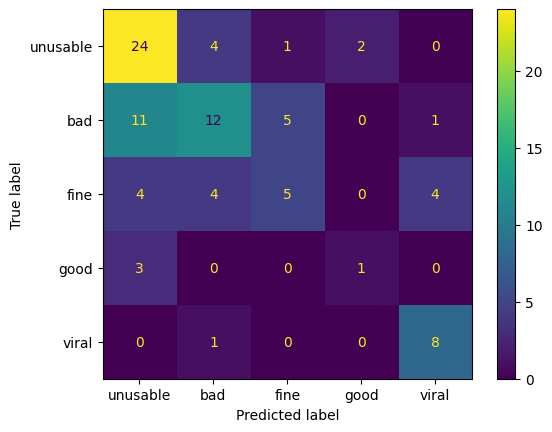

In [8]:
print("Accuracy:", accuracy)
labels = ['unusable', 'bad', 'fine', 'good', 'viral']
#labels = ['viral', 'good', 'fine', 'bad', 'unusable']
print(labels)
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels=labels)
disp.plot()
#plt.gca().set_ylim(len(labels)-0.5, -0.5)  # This line reverses the y-axis
plt.savefig('confusion_matrix.png')

In [9]:
# Save model
# Save the trained model to a file
with open('random_forest_model.pkl', 'wb') as file:
    pickle.dump(rf, file)
